In [ ]:
from AIPyS.classification.bayes.GranularityDeploy import GranularityDeploy
import glob
from IPython.display import clear_output
data_dir = '/data/kanferg/Images/Pex_project/Subrah_2024/022419_catGFP/class1/'
files = glob.glob(data_dir + '*tif')
videoName = 'KernelLoss.avi'
Image_name = files[0]
outPath = '/data/kanferg/Images/Pex_project/Subrah_2024/data'
block_size_cyto = 3
offset_cyto = -5
global_ther = 0.51
clean  = 3
channel = 0
bit8 = 20
ci = 3
start_kernel = 2
end_karnel = 50 
kernel_size = 20
outputImageSize = 800

windowSize = 6 # for example split image to 6 slides
rnadomWindows = 10 # for example add 10 more random slides
kernelGran = 4 # The kernelGran is dictated by the GranularityVideo generated video file of Granularity process
w, h = 500, 500
a = 0.19
b = -4.71
td = 0.4
expansion_factor = 1.3
tableGen = GranularityDeploy(a,b,td,expansion_factor,kernelGran, w, h, windowSize, rnadomWindows, Image_name,outPath,block_size_cyto, offset_cyto, global_ther, clean, channel, bit8, ci)
table = tableGen.predictCrop()

max image size: 1590, step size: 265


In [7]:
import torch 
print(torch.version.cuda) 

None


In [3]:
img_crudeMasked = table

In [6]:
%%timeit
from cellpose import models, core
use_GPU = core.use_gpu()
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
mask, _, _, _ = model.eval(img_crudeMasked, diameter=100, flow_threshold=None, channels = [0,0])

NameError: name '_C' is not defined

In [1]:
from AIPyS.classification.bayes.GranularityDeploy import GranularityDeploy
import glob
from IPython.display import clear_output
data_dir = '/data/kanferg/Images/Pex_project/Subrah_2024/022419_catGFP/class1/'
files = glob.glob(data_dir + '*tif')
videoName = 'KernelLoss.avi'
Image_name = files[0]
outPath = '/data/kanferg/Images/Pex_project/Subrah_2024/data'
block_size_cyto = 3
offset_cyto = -5
global_ther = 0.51
clean  = 3
channel = 0
bit8 = 20
ci = 3
start_kernel = 2
end_karnel = 50 
kernel_size = 20
outputImageSize = 800

windowSize = 6 # for example split image to 6 slides
rnadomWindows = 10 # for example add 10 more random slides
kernelGran = 4 # The kernelGran is dictated by the GranularityVideo generated video file of Granularity process
w, h = 500, 500
a = 0.19
b = -4.71
tableGen = GranularityDeploy(a,b,kernelGran, w, h, windowSize,rnadomWindows, Image_name,outPath,block_size_cyto, offset_cyto, global_ther, clean, channel, bit8, ci)
table = tableGen.predictCrop()

max image size: 1590, step size: 265


In [29]:
import numpy as np
import pandas
import string
import cv2
import pdb
import random
import skimage
import os
import pandas as pd
import glob


df = pd.DataFrame(table)
table_sel = df.loc[df['pred'] > 0.4,:]
winSize = 6
minAxsis = img.shape[1]
stepSize =  int(minAxsis/winSize)
expansion_factor = 2
img = skimage.io.imread(files[0])
table_sel

,x,y,ratio,pred
9,265,795,0.102962,0.426792
18,795,0,0.121407,0.405686
19,795,265,0.126259,0.400189
21,795,795,0.104610,0.424894


In [30]:
stepSize

330

In [25]:
img.shape[1]

(1590, 1984)

In [42]:
# mask genration

def creatCrudeMask(img,x_start,y_start,expansion_factor,winSize):
    height, width = img.shape[:2]
    center_x, center_y = x_start + winSize // 2, y_start + winSize // 2
    new_winSize = int(winSize * expansion_factor)
    center_x, center_y = x_start + winSize // 2, y_start + winSize // 2
     # Adjusting new window coordinates based on the image boundaries
    new_x_start = max(center_x - new_winSize // 2, 0)
    new_y_start = max(center_y - new_winSize // 2, 0)
    new_x_end = min(center_x + new_winSize // 2, width)
    new_y_end = min(center_y + new_winSize // 2, height)

    # Handling cases where the window hits the boundary and keeping the aspect ratio
    if new_x_end - new_x_start < new_winSize:
        diff = new_winSize - (new_x_end - new_x_start)
        new_x_start = max(new_x_start - diff, 0)
        new_x_end = min(new_x_end + diff, width)
    if new_y_end - new_y_start < new_winSize:
        diff = new_winSize - (new_y_end - new_y_start)
        new_y_start = max(new_y_start - diff, 0)
        new_y_end = min(new_y_end + diff, height)
    new_x_start = max(0, new_x_start)
    new_y_start = max(0, new_y_start)
    new_x_end = min(new_x_end, width)
    new_y_end = min(new_y_end, height)
    return (new_x_start, new_y_start, new_x_end, new_y_end)
    
mask = np.zeros_like(img)
for index, row in table_sel.iterrows():
    xs,ys,xe,ye = creatCrudeMask(img,int(row['x']),int(row['y']),expansion_factor = 1.1 ,winSize = stepSize)
    mask[xs:xe,ys:ye] = 255

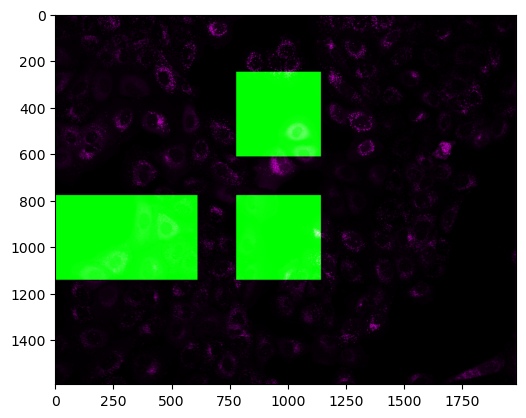

In [43]:
import matplotlib.pyplot as plt
def makeimage(imgg,maskk):
    input_gs_image = imgg*2
    input_gs_image = input_gs_image
    input_gs_image = (input_gs_image / input_gs_image.max()) * 255
    ch2_u8 = np.uint8(input_gs_image)
    mask = np.uint8(maskk)
    rgb_input_img = np.zeros((np.shape(ch2_u8)[0], np.shape(ch2_u8)[1], 3), dtype=np.uint8)
    rgb_input_img[:, :, 0] = ch2_u8
    rgb_input_img[:, :, 1] = mask
    rgb_input_img[:, :, 2] = ch2_u8
    return rgb_input_img
rgb_input_img = makeimage(img,mask)
plt.imshow(rgb_input_img)

In [48]:
img.shape

(1590, 1984)

In [46]:
# remove all the cells out of boundaries
img_crudeMasked = np.zeros_like(img)
img_crudeMasked[mask>0] = img[mask>0]

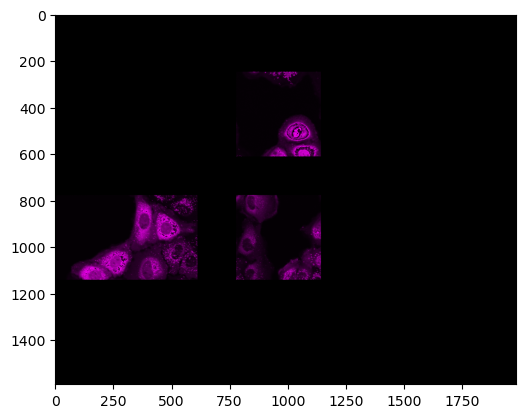

In [52]:
rgb_input_img = makeimage(img_crudeMasked*5,np.zeros_like(img))
plt.imshow(rgb_input_img)

In [53]:
from cellpose import models, core
use_GPU = core.use_gpu()
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
mask, _, _, _ = model.eval(img_crudeMasked, diameter=100, flow_threshold=None, channels = [0,0])


KeyboardInterrupt: 

In [1]:
from AIPyS.segmentation.parametric.GlobalSeg import GlobalSeg
from AIPyS.supportFunctions.GranularityFunc import GranularityFunc as gf
import numpy as np
import pandas
import string
import cv2
import pdb
import random
import skimage
import os
import pandas as pd
import glob
from PIL import Image, ImageEnhance, ImageDraw,ImageFont
from IPython.display import clear_output

ImportError: cannot import name 'GranularityFunc' from 'AIPyS.supportFunctions.GranularityFunc' (/gpfs/gsfs10/users/kanferg/Images/Pex_project/Subrah_2024/AIPyS/supportFunctions/GranularityFunc.py)

In [ ]:
data_dir = '/data/kanferg/Images/Pex_project/Subrah_2024/022419_catGFP/class1/'
files = glob.glob(data_dir + '*tif')
img = skimage.io.imread(files[0])

In [ ]:
data_dir = '/data/kanferg/Images/Pex_project/Subrah_2024/022419_catGFP/class1/'
files = glob.glob(data_dir + '*tif')
Image_name = files[0]
outPath = '/data/kanferg/Images/Pex_project/Subrah_2024/022419_catGFP/videos'
block_size_cyto = 3
offset_cyto = -5
global_ther = 0.51
clean  = 3
channel = 0,
bit8 = 50,
ci = 3
mask = GlobalSeg(Image_name,outPath,block_size_cyto, offset_cyto, global_ther, clean, channel, bit8, ci).cytosolSegmentation(img)

In [61]:
import numpy as np
def makeimage(imgg,maskk):
    input_gs_image = imgg
    input_gs_image = input_gs_image
    input_gs_image = (input_gs_image / input_gs_image.max()) * 255
    ch2_u8 = np.uint8(input_gs_image)
    mask = np.uint8(imageFrame)
    rgb_input_img = np.zeros((np.shape(ch2_u8)[0], np.shape(ch2_u8)[1], 3), dtype=np.uint8)
    rgb_input_img[:, :, 0] = ch2_u8
    rgb_input_img[:, :, 1] = maskk
    rgb_input_img[:, :, 2] = ch2_u8
    return rgb_input_img

In [42]:
minAxsis = min(img.shape[0],img.shape[1])
winSize = 6
while minAxsis % winSize != 0:
    minAxsis -= 1
stepSize =  int(minAxsis/winSize)
print(f'max image size: {minAxsis}, step size: {stepSize}')

max image size: 1590, step size: 265


In [73]:
fraemTest = np.zeros_like(img,dtype='int8')
x = np.random.randint(low = 0,high = minAxsis - stepSize ,size =1).tolist()[0]
x

1304

/tmp/ipykernel_2973593/3522987671.py:1: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 255 to int8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  fraemTest[x,x:x+stepSize] = 255
/tmp/ipykernel_2973593/3522987671.py:2: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 255 to int8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  fraemTest[x+stepSize,x:x+stepSize] = 255
/tmp/ipykernel_2973593/3522987671.py:3: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 255 to int8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the des

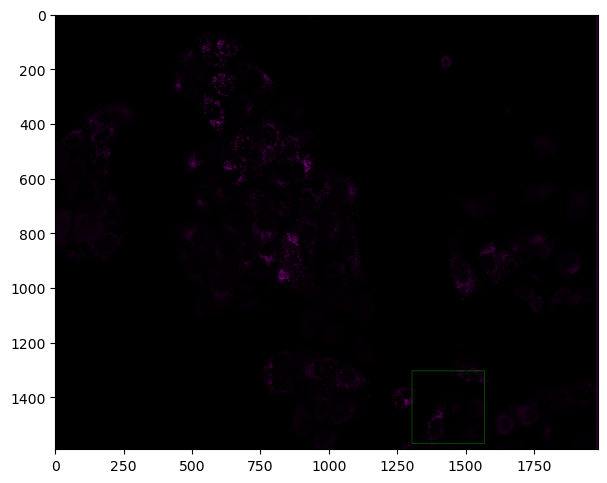

In [76]:
fraemTest[x,x:x+stepSize] = 255
fraemTest[x+stepSize,x:x+stepSize] = 255
fraemTest[x:x+stepSize,x] = 255
fraemTest[x:x+stepSize,x+stepSize] = 255
rgb_input_img = makeimage(img,fraemTest)
plt.imshow(rgb_input_img)

In [48]:
x = np.zeros((5,5))
x[1,3]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [1]:
from AIPyS.classification.bayes.GranularityDataGen import GranularityDataGen
import glob
from IPython.display import clear_output
data_dir = '/data/kanferg/Images/Pex_project/Subrah_2024/022419_catGFP/class1/'
files = glob.glob(data_dir + '*tif')
videoName = 'KernelLoss.avi'
Image_name = files[26]
outPath = '/data/kanferg/Images/Pex_project/Subrah_2024/022419_catGFP/zoomInImage'
block_size_cyto = 3
offset_cyto = -5
global_ther = 0.51
clean  = 3
channel = 0
bit8 = 20
ci = 3
start_kernel = 2
end_karnel = 50 
kernel_size = 20
outputImageSize = 800

windowSize = 6 # for example split image to 6 slides
rnadomWindows = 10 # for example add 10 more random slides
kernelGran = 4 # The kernelGran is dictated by the GranularityVideo generated video file of Granularity process
w, h = 500, 500

ImageChankGen = GranularityDataGen(kernelGran, w, h, windowSize,rnadomWindows, Image_name,outPath,block_size_cyto, offset_cyto, global_ther, clean, channel, bit8, ci)
img,imageFrame,coordinate = ImageChankGen.displayImageFrame()

max image size: 1590, step size: 265


In [7]:
coordinate["x"]

[0,
 265,
 530,
 795,
 1060,
 1325,
 0,
 265,
 530,
 795,
 1060,
 1325,
 0,
 265,
 530,
 795,
 1060,
 1325,
 0,
 265,
 530,
 795,
 1060,
 1325,
 0,
 265,
 530,
 795,
 1060,
 1325,
 0,
 265,
 530,
 795,
 1060,
 1325]

In [18]:
corr_list = [i for i in zip(coordinate["x"],coordinate["y"])]

In [39]:
import numpy as np
input_gs_image = img
input_gs_image = input_gs_image
input_gs_image = (input_gs_image / input_gs_image.max()) * 255
ch2_u8 = np.uint8(input_gs_image)
mask = np.uint8(imageFrame)
rgb_input_img = np.zeros((np.shape(ch2_u8)[0], np.shape(ch2_u8)[1], 3), dtype=np.uint8)
rgb_input_img[:, :, 0] = ch2_u8
rgb_input_img[:, :, 1] = ch2_u8
rgb_input_img[:, :, 2] = mask

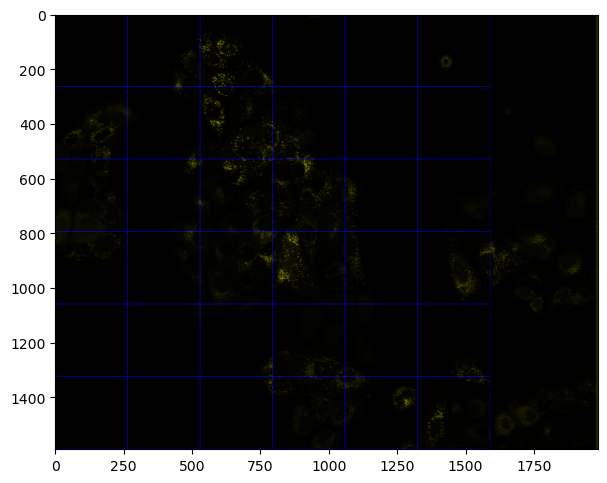

In [40]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
fig, axes = plt.subplots(1, 1)
axes.imshow(rgb_input_img)

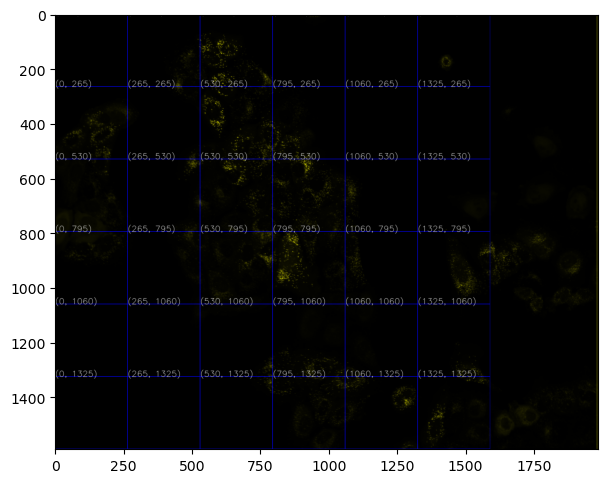

In [41]:
import cv2
inImage = rgb_input_img
for i in corr_list:
    cv2.putText(inImage, f'{i}',i , cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
plt.rcParams["figure.figsize"] = (7,7)
fig, axes = plt.subplots(1, 1)
axes.imshow(inImage)
#plt.close('all')

In [ ]:
def disply_compsite(image, mask):
    '''
    bit8 color assign 255 is very bright
    '''
    input_gs_image = image
    input_gs_image = input_gs_image*self.ci
    input_gs_image = (input_gs_image / input_gs_image.max()) * 255
    ch2_u8 = np.uint8(input_gs_image)
    rgb_input_img = np.zeros((np.shape(ch2_u8)[0], np.shape(ch2_u8)[1], 3), dtype=np.uint8)
    rgb_input_img[:, :, 0] = ch2_u8
    rgb_input_img[:, :, 1] = ch2_u8
    rgb_input_img[:, :, 2] = ch2_u8
    rgb_input_img[mask > 0, self.channel] = self.bit8
    return rgb_input_img

In [ ]:
 def addText_splitVideo(image_input,text):
    return cv2.putText(image_input, f'{text[0]}{text[1]}', (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA) #0.5 font, 1 thickness